In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

In [2]:
# Note: Need to add these files locally before running
income_file = '17zpallnoagi.csv'
mh_file = 'MarketHealthIndex_Zip.csv'

df_income = pd.read_csv(income_file)
df_mh = pd.read_csv(mh_file, encoding='unicode_escape')

print("Missing values in income data:")
print(df_income.isnull().sum())
print()

print("Missing values in market health data:")
print(df_mh.isnull().sum())

Missing values in income data:
STATEFIPS    0
STATE        0
ZIPCODE      0
AGI_STUB     0
N1           0
            ..
A11900       0
N11902       0
A11902       0
N12000       0
A12000       0
Length: 153, dtype: int64

Missing values in market health data:
RegionType                  0
RegionName                  0
City                        0
State                       0
Metro                     600
CBSATitle                 600
SizeRank                14089
MarketHealthIndex           0
SellForGain              4609
PrevForeclosed          11544
ForeclosureRatio        10836
ZHVI                      130
MoM                       130
YoY                       130
ForecastYoYPctChange     2743
StockOfREOs             14089
NegativeEquity            395
Delinquency               395
DaysOnMarket              127
dtype: int64


In [3]:
# Drop rows with null values for ZHVI
df_mh = df_mh.dropna(subset=['ZHVI'])
print(df_mh.isnull().sum())

RegionType                  0
RegionName                  0
City                        0
State                       0
Metro                     598
CBSATitle                 598
SizeRank                13959
MarketHealthIndex           0
SellForGain              4609
PrevForeclosed          11496
ForeclosureRatio        10812
ZHVI                        0
MoM                         0
YoY                         0
ForecastYoYPctChange     2613
StockOfREOs             13959
NegativeEquity            395
Delinquency               395
DaysOnMarket              127
dtype: int64


Missing values before imputing:
RegionType                  0
RegionName                  0
City                        0
State                       0
Metro                     598
CBSATitle                 598
SizeRank                13959
MarketHealthIndex           0
SellForGain              4609
PrevForeclosed          11496
ForeclosureRatio        10812
ZHVI                        0
MoM                         0
YoY                         0
ForecastYoYPctChange     2613
StockOfREOs             13959
NegativeEquity            395
Delinquency               395
DaysOnMarket              127
dtype: int64

Missing delinquency: 395
--------------------------------------------------
Missing values after imputing:
RegionType                  0
RegionName                  0
City                        0
State                       0
Metro                     597
CBSATitle                 597
SizeRank                13829
MarketHealthIndex           0
SellForGain                 0
PrevFor

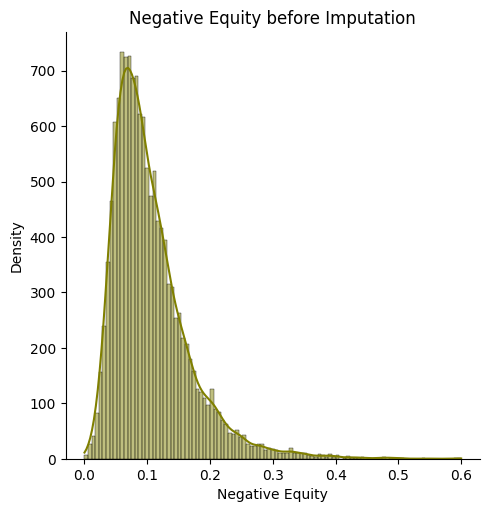

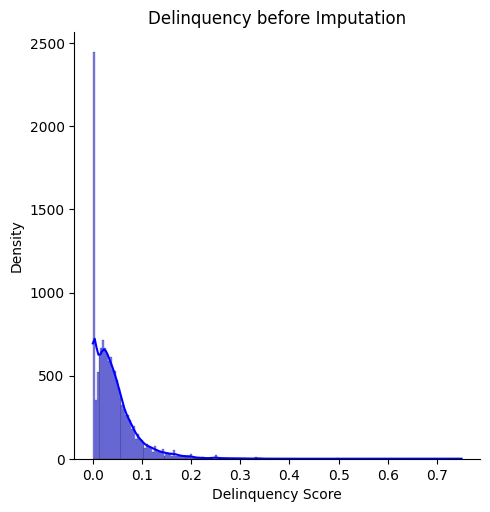

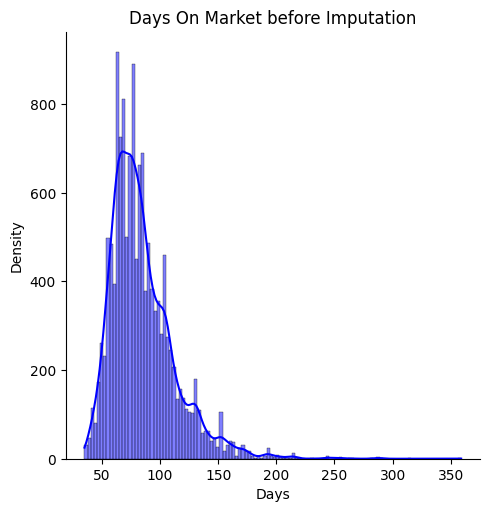

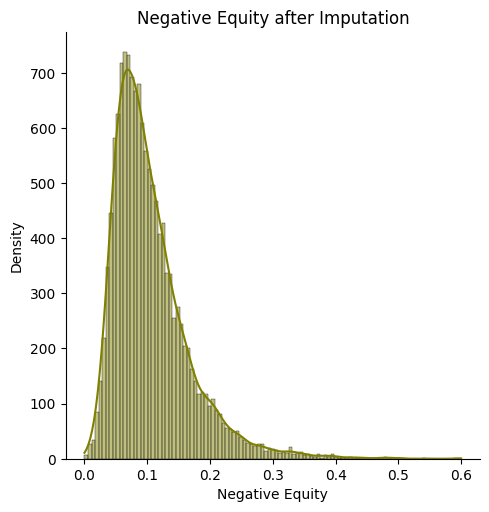

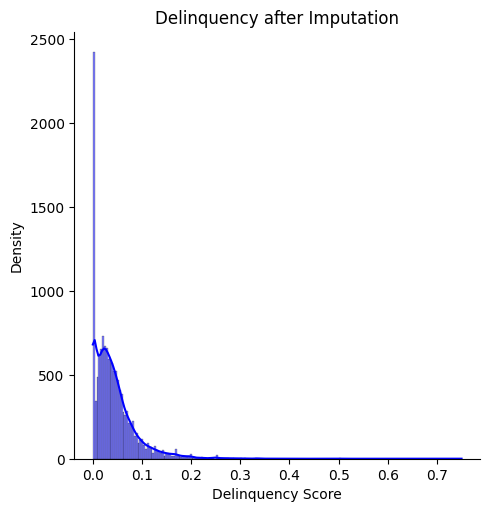

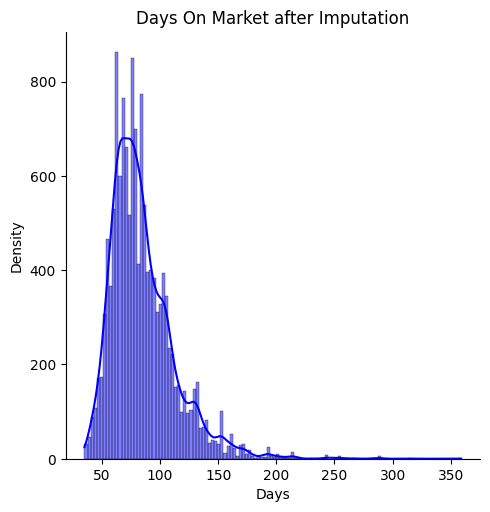

In [4]:
# Impute missing values for home value data filter
imputer = KNNImputer()

excluded_columns = ['RegionType', 'RegionName', 'City', 'State', 'Metro', 'CBSATitle', 'SizeRank', 'StockOfREOs']

columns_for_impute = [col for col in df_mh.columns if col not in excluded_columns]

df_mh_impute_values = df_mh[columns_for_impute]

print('Missing values before imputing:')
print(df_mh.isnull().sum())
print()

sns.displot(df_mh, x=df_mh['NegativeEquity'],  kde = True, color="olive", label = 'NegativeEquity')
# ax1.set(xticks=(0,9000000))

plt.title('Negative Equity before Imputation')
plt.xlabel('Negative Equity')
plt.ylabel('Density')
missing_neg_equity = df_mh['NegativeEquity'].isnull().sum()

sns.displot(df_mh, x=df_mh['Delinquency'], kde = True, color="blue", label = 'Delinquency')

plt.title('Delinquency before Imputation')
plt.xlabel('Delinquency Score')
plt.ylabel('Density')
missing_delinquency = df_mh['Delinquency'].isnull().sum()

sns.displot(df_mh, x=df_mh['DaysOnMarket'], kde = True, color="blue", label = 'DaysOnMarket')

plt.title('Days On Market before Imputation')
plt.xlabel('Days')
plt.ylabel('Density')
missing_days_on_market = df_mh['DaysOnMarket'].isnull().sum()

df_mh_impute_values = imputer.fit_transform(df_mh_impute_values)

# Make the imputed values into a dataframe
df_mh_impute_values = pd.DataFrame(df_mh_impute_values, columns=columns_for_impute)


df_mh[columns_for_impute] = df_mh_impute_values[columns_for_impute]

df_mh = df_mh.dropna(subset=['ZHVI'])  # Note: This should not be necessary
print('-'*50)
print('Missing values after imputing:')
print(df_mh.isnull().sum())

sns.displot(df_mh, x=df_mh['NegativeEquity'],  kde = True, color="olive", label = 'NegativeEquity')
# ax1.set(xticks=(0,9000000))

plt.title('Negative Equity after Imputation')
plt.xlabel('Negative Equity')
plt.ylabel('Density')
print(f'Percent negative equity imputed: {missing_neg_equity/len(df_mh)*100:.2f}%')

sns.displot(df_mh, x=df_mh['Delinquency'], kde = True, color="blue", label = 'Delinquency')

plt.title('Delinquency after Imputation')
plt.xlabel('Delinquency Score')
plt.ylabel('Density')
print(f'Percent delinquency imputed: {missing_delinquency/len(df_mh)*100:.2f}%')

sns.displot(df_mh, x=df_mh['DaysOnMarket'], kde = True, color="blue", label = 'DaysOnMarket')

plt.title('Days On Market after Imputation')
plt.xlabel('Days')
plt.ylabel('Density')
print(f'Percent days on market imputed: {missing_days_on_market/len(df_mh)*100:.2f}%')



In [5]:
Income_Returns = df_income.groupby(['STATE']).sum().reset_index()
Market_Health_Zips = df_mh['RegionName'].tolist()
print(Market_Health_Zips)

Income_Returns_Reduced = df_income[df_income['ZIPCODE'].isin(Market_Health_Zips)]

Income_Market_Returns = Income_Returns_Reduced.groupby(['STATE']).sum().reset_index()


# Divide the N1 value of the income data by the N1 value of the income data for the states in the market health data
Income_Returns['Ratio'] = Income_Returns['N1'] / Income_Market_Returns['N1']

merged_df = pd.merge(Income_Returns, Income_Market_Returns, on='STATE', how='inner')

merged_df['Ratio'] = merged_df['N1_y'] / merged_df['N1_x']

print(merged_df.head())

import plotly.express as px

# May need pip install --upgrade nbformat

fig = px.choropleth(merged_df, locations="STATE", color="Ratio", hover_name="STATE", locationmode='USA-states', scope='usa', color_continuous_scale="Viridis")

fig.show()


[1001, 1002, 1005, 1007, 1008, 1010, 1011, 1013, 1020, 1022, 1026, 1027, 1028, 1030, 1033, 1034, 1035, 1036, 1038, 1040, 1050, 1053, 1054, 1056, 1057, 1060, 1062, 1068, 1069, 1071, 1072, 1073, 1075, 1077, 1080, 1081, 1082, 1083, 1085, 1089, 1095, 1096, 1098, 1104, 1105, 1106, 1107, 1108, 1109, 1118, 1119, 1128, 1129, 1151, 1201, 1220, 1223, 1225, 1226, 1235, 1237, 1238, 1240, 1245, 1247, 1253, 1254, 1255, 1257, 1262, 1266, 1267, 1270, 1301, 1330, 1331, 1337, 1338, 1339, 1340, 1341, 1351, 1354, 1360, 1364, 1366, 1368, 1370, 1373, 1375, 1376, 1420, 1430, 1431, 1432, 1440, 1450, 1451, 1452, 1453, 1460, 1462, 1463, 1464, 1468, 1469, 1473, 1474, 1475, 1501, 1503, 1504, 1505, 1506, 1507, 1510, 1515, 1516, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1527, 1529, 1532, 1534, 1535, 1536, 1537, 1540, 1541, 1542, 1543, 1545, 1550, 1560, 1562, 1564, 1566, 1568, 1569, 1570, 1571, 1581, 1583, 1585, 1588, 1590, 1602, 1603, 1604, 1605, 1606, 1607, 1609, 1610, 1611, 1612, 1701, 1702, 1719, 1720, 1721, 173